In [129]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [130]:
grades = pd.read_csv('data/expert_scores.csv')

#Change NaN values to avg score of a given expert in given category
grades['innovation'] = grades['innovation'].fillna(grades.groupby('expert')['innovation'].transform('mean'))
grades['aesthetics'] = grades['aesthetics'].fillna(grades.groupby('expert')['aesthetics'].transform('mean'))
grades['value'] = grades['value'].fillna(grades.groupby('expert')['value'].transform('mean'))

grades.head()

,group,expert,innovation,aesthetics,value,surprise
0,1,1,2.000000,5.0,3.0,2.0
1,1,2,3.000000,3.0,3.0,3.0
2,1,3,4.000000,4.0,4.0,3.0
3,1,4,4.000000,5.0,4.0,4.0
4,1,5,3.192308,3.0,3.0,3.0


In [131]:
project_scores = grades.groupby('group').mean()
project_scores.drop(columns='expert', inplace=True)
project_scores["Average"] = project_scores.mean(axis=1)
project_scores

,innovation,aesthetics,value,surprise,Average
group,,,,,
1,3.308858,4.090909,3.751748,2.666667,3.454545
2,3.745455,4.121212,3.757576,2.909091,3.633333
3,3.666667,3.606061,3.333333,3.242424,3.462121
4,4.030303,4.030303,4.151515,3.333333,3.886364
5,3.121212,2.787879,2.732543,2.818182,2.864954
6,2.442424,2.848485,2.702240,1.878788,2.467984
7,2.848485,2.909091,2.909091,2.272727,2.734848
8,3.737762,3.197628,3.156785,3.454545,3.386680
9,3.121212,2.918415,3.060606,2.545455,2.911422


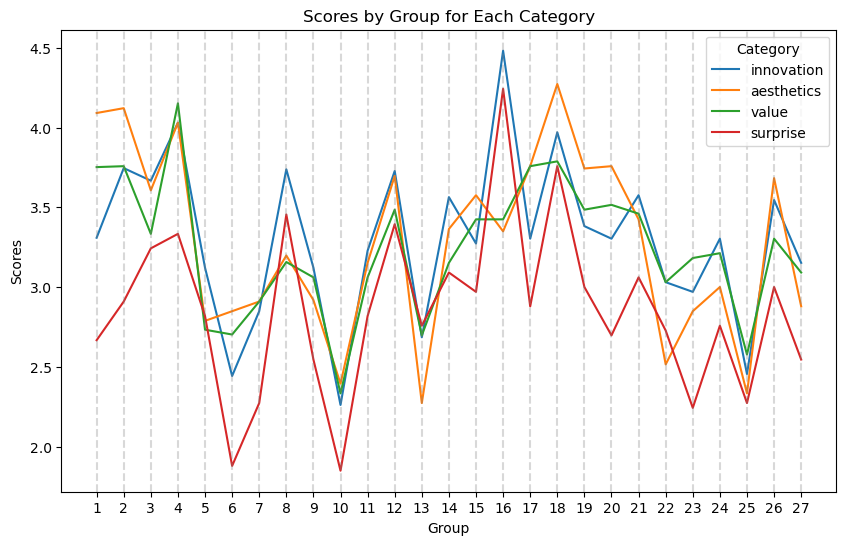

In [132]:
import numpy as np

plt.figure(figsize=(10, 6))

for column in ["innovation", "aesthetics", "value", "surprise"]:
    plt.plot(project_scores.index, project_scores[column], label=column)

for x in project_scores.index:
    plt.axvline(x, color="gray", linestyle="dashed", alpha=0.3)
    
plt.xlabel("Group")
plt.ylabel("Scores")
plt.title("Scores by Group for Each Category")
plt.xticks(np.arange(1, 28, step=1))
plt.legend(title="Category")

# Show the plot
plt.show()

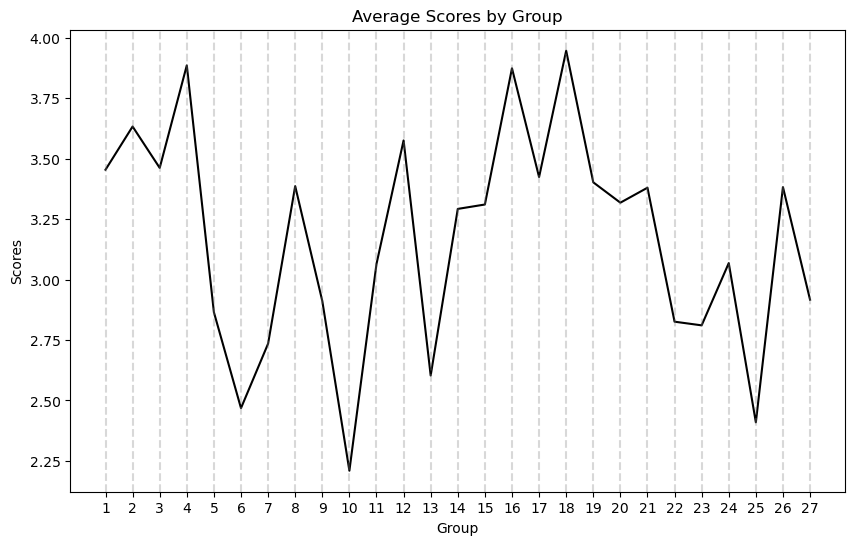

In [133]:
plt.figure(figsize=(10, 6))

plt.plot(project_scores.index, project_scores["Average"], label="Average", color="black")

for x in project_scores.index:
    plt.axvline(x, color="gray", linestyle="dashed", alpha=0.3)

plt.xlabel("Group")
plt.ylabel("Scores")
plt.title("Average Scores by Group")
plt.xticks(np.arange(1, 28, step=1))

plt.show()

In [134]:
metrics = ['Color_Similarity', 'ResNet_Similarity', 'Dino_Similarity', 'Contrast_Similarity']

combined_df = pd.read_csv("csv/all_similarities_with_srcs.csv")
combined_df.head()

,Final_Submission,Inspiration,Color_Similarity,ResNet_Similarity,Dino_Similarity,Contrast_Similarity,Source
0,1_1.png,1A_1.jpg,0.529821,0.797856,0.823561,0.744530,Web
1,1_1.png,1A_10.jpg,0.858951,0.604741,0.716302,0.624540,Web
2,1_1.png,1A_2.jpg,0.751328,0.615733,0.370060,0.883636,Web
3,1_1.png,1A_3.jpg,0.720056,0.551096,0.477145,0.869095,Web
4,1_1.png,1A_4.jpg,0.769988,0.652863,0.437572,0.813474,Web


In [135]:
#Positive score is WEB negative is AI
#Complicated shit

def get_ai_web_scores(group_id, alpha = 0.05):
    
    
    filtered_df = combined_df[
        combined_df["Final_Submission"].str.startswith(f"{group_id}_")
    ]
    
    if filtered_df.empty:
        return [None, None, None, None]

    combined_df_melted = pd.melt(
        filtered_df,
        id_vars=["Final_Submission", "Source"],
        value_vars=metrics,
        var_name="Metric",
        value_name="Similarity",
    )

    combined_df_melted["Metric"] = pd.Categorical(
        combined_df_melted["Metric"], categories=metrics, ordered=True
    )
    
    data = (
        combined_df_melted.sort_values(
            ["Final_Submission", "Metric", "Source", "Similarity"],
            ascending=[True, True, False, False],
        )
        .groupby(["Final_Submission", "Metric", "Source"], observed=True)
        .head(3)
    )
    
    results = []
    
    for metric in metrics:
        ai_voting_pool = []
        web_voting_pool = []
        
        for submission in data.Final_Submission.unique():
            ai_similarities = (
            data[(data.Final_Submission == submission) & (data.Source == "AI") & (data.Metric == metric)]
            .sort_values(by="Similarity", ascending=False)["Similarity"]
            .tolist()
            )

            web_similarities = (
                data[(data.Final_Submission == submission) & (data.Source == "Web") & (data.Metric == metric)]
                .sort_values(by="Similarity", ascending=False)["Similarity"]
                .tolist()
            )

            i = 0
            significant_found = False

            while i < min(len(ai_similarities), len(web_similarities)):
                ai_top = ai_similarities[i]
                web_top = web_similarities[i]
                diff = web_top - ai_top

                if diff > alpha:
                    web_voting_pool.append(sum(web_similarities[: i + 1]) / (i + 1))
                    significant_found = True
                    break
                elif diff < -alpha:
                    ai_voting_pool.append(sum(ai_similarities[: i + 1]) / (i + 1))
                    significant_found = True
                    break

                i += 1

            if not significant_found:
                avg_web = sum(web_similarities[:i]) / i if i > 0 else 0
                avg_ai = sum(ai_similarities[:i]) / i if i > 0 else 0
                web_voting_pool.append(avg_web)
                ai_voting_pool.append(avg_ai)

        ai_weight = sum(ai_voting_pool)
        web_weight = sum(web_voting_pool)
        result = web_weight - ai_weight
        results.append(result)
            
    
    
    
    return results

scores = get_ai_web_scores(1)
scores

[4.676779647637146, 1.8526050697433116, -0.1968113138445, 0.9292291243486765]

In [136]:
project_scores[metrics] = pd.DataFrame([get_ai_web_scores(i) for i in range(1, 28)], index=project_scores.index)

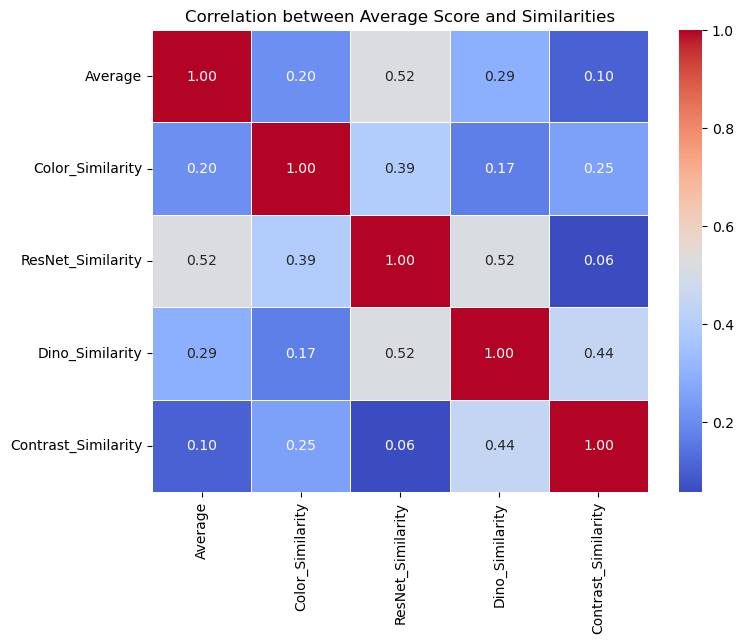

In [137]:
corr_matrix = project_scores[['Average', 'Color_Similarity', 'ResNet_Similarity', 'Dino_Similarity', 'Contrast_Similarity']].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation between Average Score and Similarities")
plt.show()

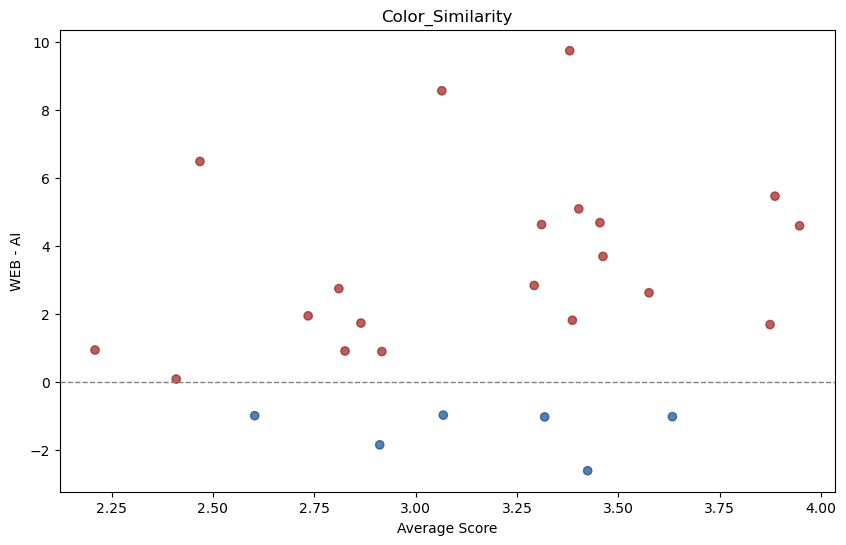

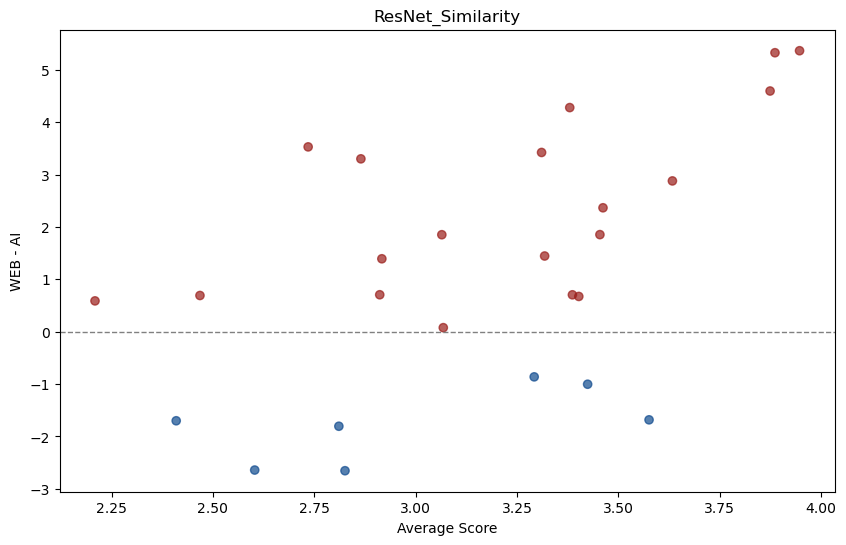

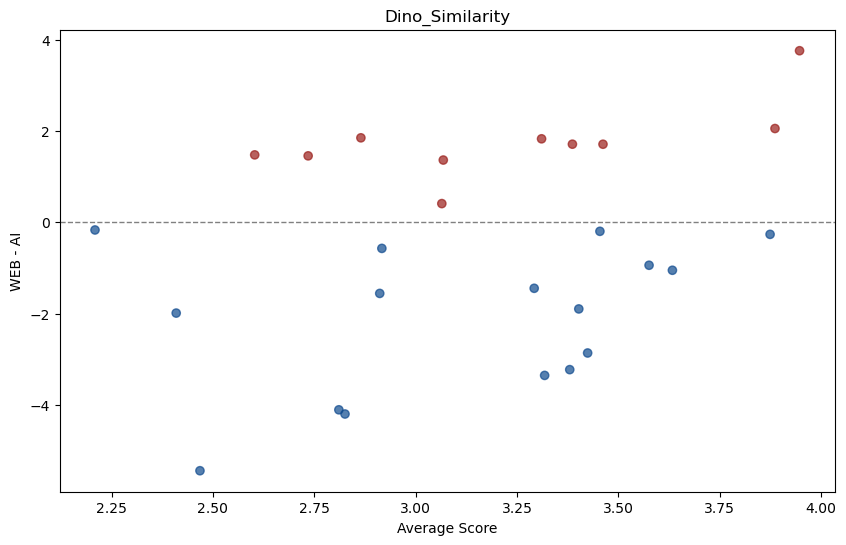

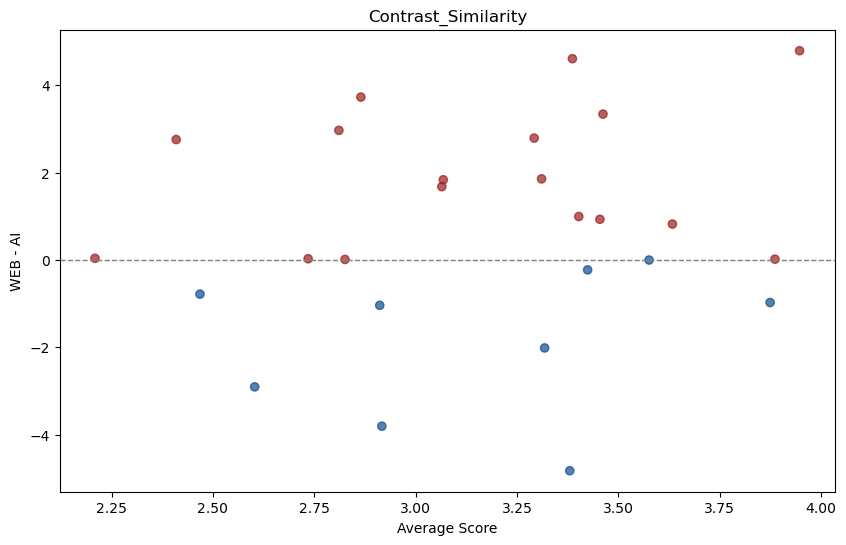

In [138]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    
    custom_palette = {"AI": "#0F4A8E", "Web": "#9A1E1A"}
    
    
    colors = np.where(project_scores[metric] >= 0, custom_palette["Web"], custom_palette["AI"])

    plt.scatter(project_scores["Average"], project_scores[metric], c=colors, alpha=0.7, label=metric)

    
    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1) 
    
    plt.xlabel("Average Score")
    plt.ylabel("WEB - AI")
    plt.title(f"{metric}")
    plt.show()
    